In [9]:
import numpy as np
import pandas as pd
import json
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import pickle

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
cd drive/MyDrive/amazon_reviews

/content/drive/MyDrive/amazon_reviews


In [12]:
df = pd.read_json('Fashion.json', lines=True)

In [13]:
df = df[['overall', 'reviewTime', 'reviewText', 'summary']]
df.reviewText = df.reviewText.astype(str)
df.summary = df.summary.astype(str)

In [72]:
print(len(df))

883636


In [ ]:
df.head(10)

,overall,reviewTime,reviewText,summary
0,5,"10 20, 2014",Exactly what I needed.,perfect replacements!!
1,2,"09 28, 2014","I agree with the other review, the opening is ...","I agree with the other review, the opening is ..."
2,4,"08 25, 2014",Love these... I am going to order another pack...,My New 'Friends' !!
3,2,"08 24, 2014",too tiny an opening,Two Stars
4,3,"07 27, 2014",Okay,Three Stars
5,5,"07 19, 2014",Exactly what I wanted.,Five Stars
6,4,"05 31, 2014",These little plastic backs work great. No mor...,Works great!
7,3,"09 22, 2013",mother - in - law wanted it as a present for h...,bought as a present
8,3,"07 17, 2013","Item is of good quality. Looks great, too. But...",Buxton heiress collection
9,3,"04 13, 2013",I had used my last el-cheapo fake leather ciga...,Top Clasp Broke Within 3 days!


In [ ]:
df['overall']

0         5
1         2
2         4
3         2
4         3
         ..
883631    5
883632    5
883633    3
883634    3
883635    5
Name: overall, Length: 883636, dtype: int64

<Axes: xlabel='overall', ylabel='count'>

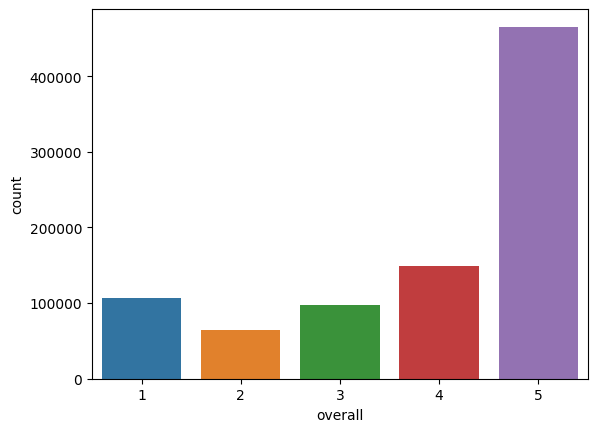

In [53]:
sns.countplot(x='overall', data=df)

In [54]:
def clean_text(raw_text):
    prepared_text = raw_text.lower()

    # 1. Remove Punctuation marks
    prepared_text = prepared_text.translate(prepared_text.maketrans("", "", string.punctuation))

    # 2. Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = prepared_text.split()
    tokens = [word for word in tokens if word not in stop_words]

    # 3. Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return " ".join(tokens)

def rating_to_sentiment(x):
    if x == 5.0 or x==4.0:
        return "good"
    elif x==3.0:
        return "average"
    return "bad"

def get_top_n_bigram(data, n=None):
    vec = CountVectorizer(ngram_range=(2, 2),stop_words='english').fit(data.values.astype('U'))
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def n_gram_plot(data, title, color):
    x=[x[0] for x in data]
    y=[x[1] for x in data]
    sns.barplot(y=x,x=y,color='{}'.format(color))
    plt.title('{} Reviews Bigrams'.format(title),fontsize=15)
    plt.yticks(rotation=0,fontsize=15)

def word_cloud(data):
    wordcloud = WordCloud(
    background_color = "white",
    max_font_size = 40,
    max_words = 200,
    stopwords = stopwords.words("english"),
    scale = 3).generate(str(data))
    fig = plt.figure(figsize = (7.5, 7.5))
    plt.axis("off")
    plt.imshow(wordcloud)
    plt.show()

In [55]:
df.iloc[10]['reviewText']

'This brand has been around a long time and you can count on good quality merchandise.  Held up well with no rips or stitching problems!'

In [56]:
clean_text(df.iloc[0]['reviewText'])

'exactli need'

In [ ]:
df['cleaned_reviews'] = df['reviewText'].apply(lambda x: clean_text(x))

In [ ]:
df['cleaned_summary'] = df['summary'].apply(lambda x: clean_text(x))

In [ ]:
df['word_count'] = df["reviewText"].apply(lambda x: len(str(x).split(" ")))
df['review_len'] =df["reviewText"].apply(lambda x: len(str(x)))

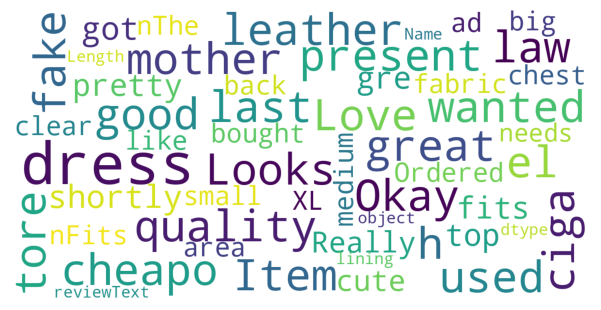

In [60]:
word_cloud(df[df['overall']==3]["reviewText"])

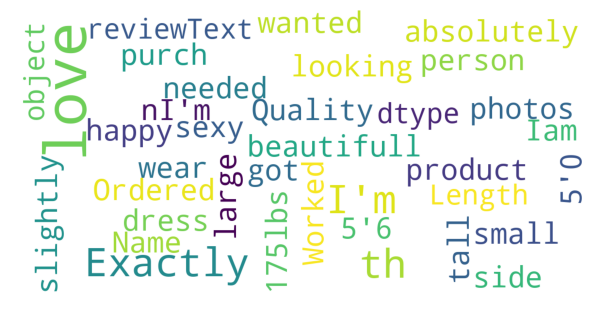

In [61]:
word_cloud(df[df['overall']==5]["reviewText"])

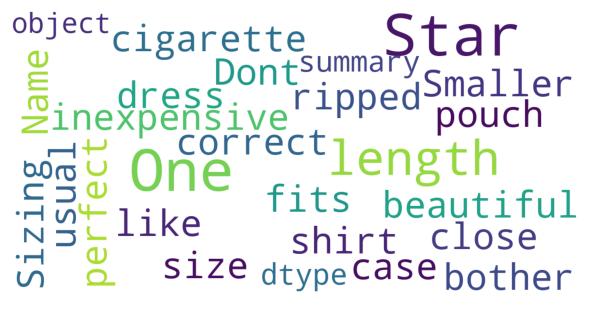

In [62]:
word_cloud(df[df['overall']==1]["summary"])

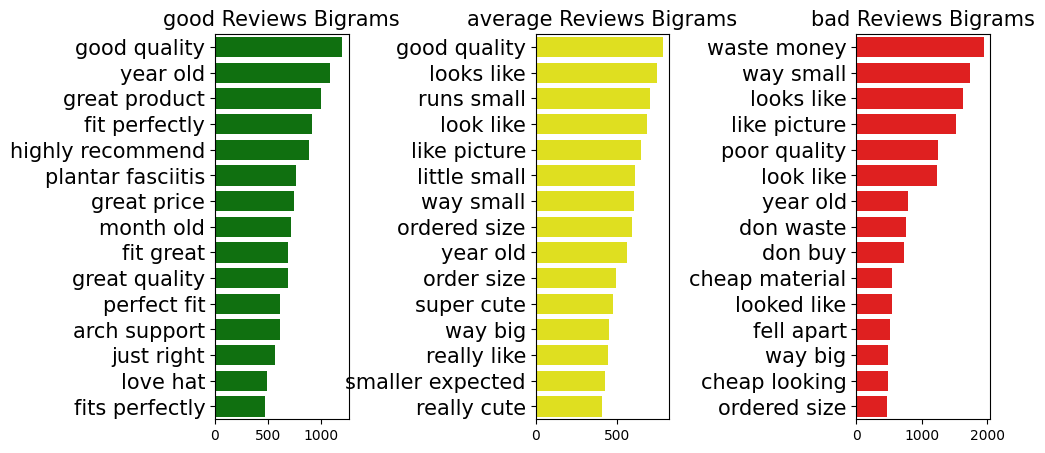

In [67]:
common_words_5 = get_top_n_bigram(df[df['overall']==5]['reviewText'][:50000], 15)
common_words_3 = get_top_n_bigram(df[df['overall']==3]['reviewText'][:50000], 15)
common_words_1 = get_top_n_bigram(df[df['overall']==1]['reviewText'][:50000], 15)

plt.figure(figsize=(10,5))
plt.subplot(151)
n_gram_plot(common_words_5,'good','green')
plt.subplot(153)
n_gram_plot(common_words_3,'average','yellow')
plt.subplot(155)
n_gram_plot(common_words_1,'bad','red')

plt.show()

In [ ]:
correlation = df[['overall', 'review_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,5))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 12}, linewidths=10, vmin=-1.5, mask=mask)

## Sentiment Analysis

In [16]:
df_select = df[:50000]
msk = np.random.rand(len(df_select)) < 0.8
df_train = df_select[msk]
df_test = df_select[~msk]
X_train_class = df_train["reviewText"]
Y_train_class = df_train["overall"]
X_test_class = df_test["reviewText"]
Y_test_class = df_test["overall"]

In [ ]:
len(X_train_class)

In [17]:
tfidf_vectorizer = TfidfVectorizer(min_df= 3, sublinear_tf=True, norm='l2', ngram_range=(1,1))
counter_vectorizer = CountVectorizer(ngram_range=(1,1))
text_clf_classifier1 = Pipeline([('vect', counter_vectorizer),('chi',  SelectKBest(chi2, k=1200)),('clf', RandomForestClassifier()),])

In [18]:
def run_model(text_clf_classifier):
  print(text_clf_classifier)
  classifier_model = text_clf_classifier.fit(X_train_class,Y_train_class)
  print(np.mean(classifier_model.predict(X_test_class)== Y_test_class))

In [19]:
print("Random Forest Classifier - Count Vectorizer:")
run_model(text_clf_classifier1)

Random Forest Classifier - Count Vectorizer:
Pipeline(steps=[('vect', CountVectorizer()),
                ('chi',
                 SelectKBest(k=1200,
                             score_func=<function chi2 at 0x7caf6a48e320>)),
                ('clf', RandomForestClassifier())])
0.8054086418521106


In [20]:
classifier_model = text_clf_classifier1.fit(X_train_class,Y_train_class)

In [22]:
def prediction(clf, review):
  prediction_df = pd.DataFrame([[review,0]],columns = ["reviewText","y"])
  # prediction_df = text_process(prediction_df)
  classifier_prediction = clf.predict(prediction_df["reviewText"])
  print(clf.predict_proba(prediction_df["reviewText"]))
  return classifier_prediction[0]

In [23]:
prediction(classifier_model, "works good, viewing angle critical for good picture. purchased for use in a rv so the size was perfect for the location")

[[0.01       0.01       0.03       0.13619048 0.81380952]]


5

In [48]:
prediction(classifier_model, "These little plastic backs work great.  No more loosing 'hook' earrings!  Wish I had ordered these sooner before I had lost some of my favorite earrings!")

[[0.   0.01 0.03 0.72 0.24]]


4

In [25]:
s = pickle.dumps(classifier_model)

In [29]:
with open('default_clf.pkl', 'wb') as f:
    pickle.dump(classifier_model, f)

In [34]:
with open('default_clf.pkl', 'rb') as f:
  clf2 = pickle.load(f)

In [35]:
prediction(clf2, 'this looks beautiful')

[[0.   0.   0.24 0.   0.76]]


5